In [37]:
!pip install transformers datasets torch scikit-learn accelerate


In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score


In [ ]:
df = pd.read_csv("/data/msrstratified_sample_1000.csv")

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["vul"].value_counts())

df.head()


Dataset Shape: (1000, 36)

Class Distribution:
vul
0    570
1    430
Name: count, dtype: int64


,Unnamed: 0,Access Gained,Attack Origin,Authentication Required,Availability,CVE ID,CVE Page,CWE ID,Complexity,Confidentiality,...,lang,lines_after,lines_before,parentID,patch,project,project_after,project_before,vul,vul_func_with_fix
0,183429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,C,if (cur->type == XML_NAMESPACE_DECL)\n...,if ((ctxt->context->node->type == XML_ATTR...,NaN,"@@ -8106,17 +8106,17 @@ xmlXPathNextPrecedingS...",Chrome,a44b00c88bc5ea35b5b150217c5fd6e4ce168e58,eef2c2ed6ea089b49c0f6468154d5a4d524abaeb,1,xmlXPathNextPrecedingInternal(xmlXPathParserCo...
1,182714,NaN,Remote,Not required,NaN,CVE-2019-15162,https://www.cvedetails.com/cve/CVE-2019-15162/,CWE-345,Low,Partial,...,C,\tDWORD error;\n\tchar errmsgbuf[PCAP_ERRBUF_S...,"\t\tpcap_fmt_errmsg_for_win32_err(errbuf, PCAP...",NaN,"@@ -1176,20 +1176,33 @@ daemon_AuthUserPwd(cha...",libpcap,484d60cbf7ca4ec758c3cbb8a82d68b244a78d58,437b273761adedcbd880f714bfa44afeec186a31,1,"daemon_AuthUserPwd(char *username, char *passw..."
2,58904,NaN,Local,Not required,Partial,CVE-2017-1000252,https://www.cvedetails.com/cve/CVE-2017-1000252/,CWE-20,Low,NaN,...,C,NaN,NaN,NaN,"@@ -565,6 +565,8 @@ kvm_irqfd(struct kvm *kvm,...",linux,36ae3c0a36b7456432fedce38ae2f7bd3e01a563,51aa68e7d57e3217192d88ce90fd5b8ef29ec94f,0,"void kvm_notify_acked_irq(struct kvm *kvm, uns..."
3,178497,NaN,Remote,Not required,Partial,CVE-2015-3146,https://www.cvedetails.com/cve/CVE-2015-3146/,NaN,Low,NaN,...,C,int rc = SSH_ERROR;\n\nerror:\n if (rc == S...,int rc;\n if (rc == SSH_ERROR)\n error:\n,d2a990a68ea555d7003edc94eb076356604facea,"@@ -165,7 +165,7 @@ static int ssh_server_kexd...",libssh,https://git.libssh.org/projects/libssh.git/tre...,https://git.libssh.org/projects/libssh.git/tre...,1,SSH_PACKET_CALLBACK(ssh_packet_kexdh_init){\n...
4,186170,NaN,Remote,Not required,Complete,CVE-2016-1639,https://www.cvedetails.com/cve/CVE-2016-1639/,NaN,Low,Complete,...,C,for (auto it = users_.cbegin(); it != users_...,for (user_manager::UserList::iterator it = u...,NaN,"@@ -99,7 +99,7 @@ bool GetEnterpriseDomain(std...",Chrome,c66b1fc49870c514b1c1e8b53498153176d7ec2b,8541637904013cfeca56a4700ba82ee8c463594f,1,void UserSelectionScreen::OnBeforeUserRemoved...


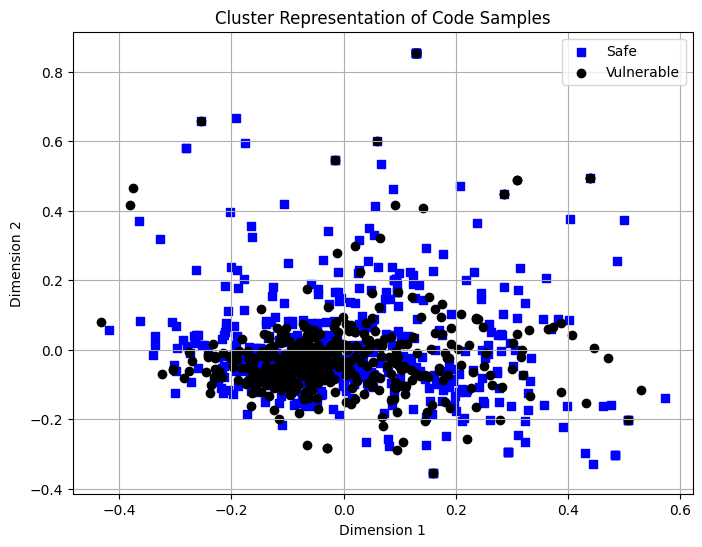

In [40]:
# Convert code text to numeric features
vectorizer = TfidfVectorizer(max_features=500)
X_features = vectorizer.fit_transform(df["func_before"].astype(str))

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_cluster = pca.fit_transform(X_features.toarray())

labels = df["vul"].values

plt.figure(figsize=(8,6))

# Safe = Blue squares
plt.scatter(
    X_cluster[labels == 0, 0],
    X_cluster[labels == 0, 1],
    c='blue',
    marker='s',
    label='Safe'
)

# Vulnerable = Black circles
plt.scatter(
    X_cluster[labels == 1, 0],
    X_cluster[labels == 1, 1],
    c='black',
    marker='o',
    label='Vulnerable'
)

plt.title("Cluster Representation of Code Samples")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# Select the relevant columns ('func_before' as code, 'vul' as label)

df = df[['func_before', 'vul']].dropna()
df.rename(columns={'func_before': 'code', 'vul': 'label'}, inplace=True)


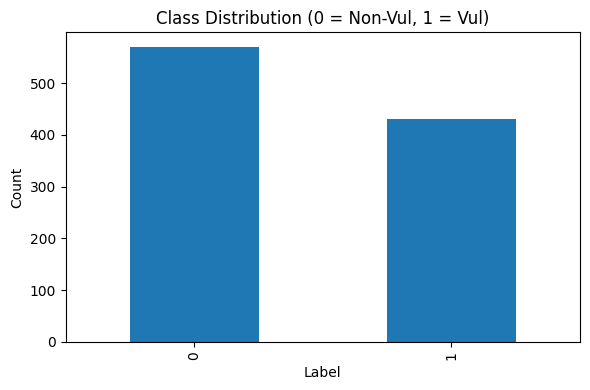

In [42]:
#class distribution

plt.figure(figsize=(6,4))
df["label"].value_counts().sort_index().plot(kind="bar")
plt.title("Class Distribution (0 = Non-Vul, 1 = Vul)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

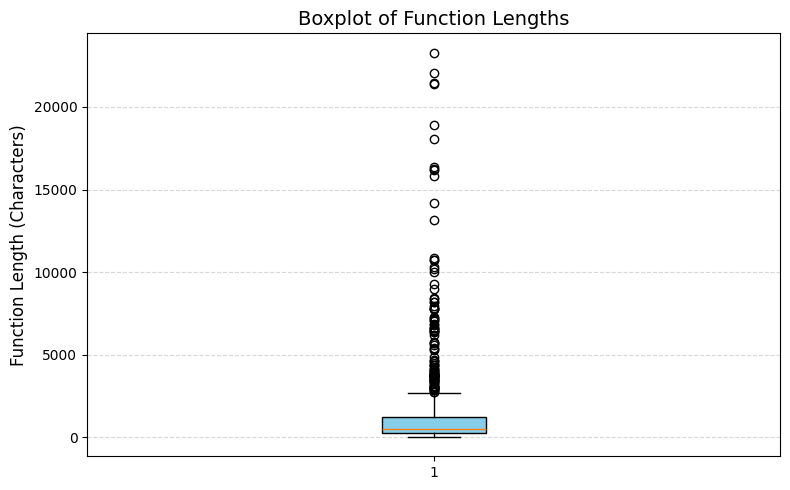

Mean function length: 1329.97
Median function length: 540.0
95th percentile: 5385.999999999997
99th percentile cutoff used: 23325.299999999963


In [43]:

# Function Length Boxplot

df["func_length"] = df["code"].astype(str).apply(len)


# Remove extreme outliers (top 1%)

percentile_99 = df["func_length"].quantile(0.99)
clean_df = df[df["func_length"] <= percentile_99]


# Boxplot
plt.figure(figsize=(8,5))
plt.boxplot(
    clean_df["func_length"],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor="skyblue")
)

plt.title("Boxplot of Function Lengths", fontsize=14)
plt.ylabel("Function Length (Characters)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Print statistics

print("Mean function length:", round(clean_df['func_length'].mean(), 2))
print("Median function length:", clean_df['func_length'].median())
print("95th percentile:", clean_df['func_length'].quantile(0.95))
print("99th percentile cutoff used:", percentile_99)


/tmp/ipython-input-622041988.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


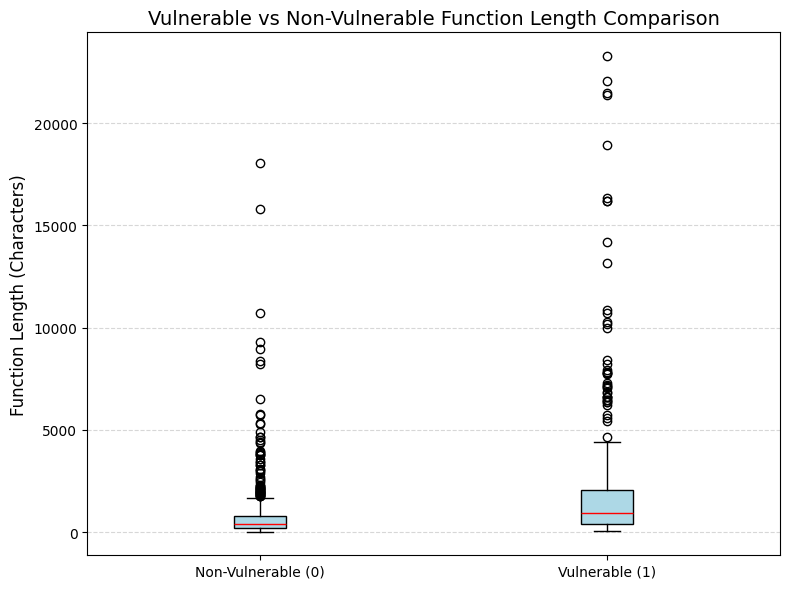

Average Non-Vulnerable Length: 839.33
Average Vulnerable Length: 1990.35
Median Non-Vulnerable Length: 378.0
Median Vulnerable Length: 920.0


In [44]:

vul_lengths = clean_df[clean_df["label"] == 1]["func_length"]
nonvul_lengths = clean_df[clean_df["label"] == 0]["func_length"]


# Plot Boxplots

plt.figure(figsize=(8,6))
plt.boxplot(
    [nonvul_lengths, vul_lengths],
    labels=["Non-Vulnerable (0)", "Vulnerable (1)"],
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="red")
)

plt.title("Vulnerable vs Non-Vulnerable Function Length Comparison", fontsize=14)
plt.ylabel("Function Length (Characters)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Statistics

print("Average Non-Vulnerable Length:", round(nonvul_lengths.mean(), 2))
print("Average Vulnerable Length:", round(vul_lengths.mean(), 2))
print("Median Non-Vulnerable Length:", nonvul_lengths.median())
print("Median Vulnerable Length:", vul_lengths.median())

/tmp/ipython-input-1545441869.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


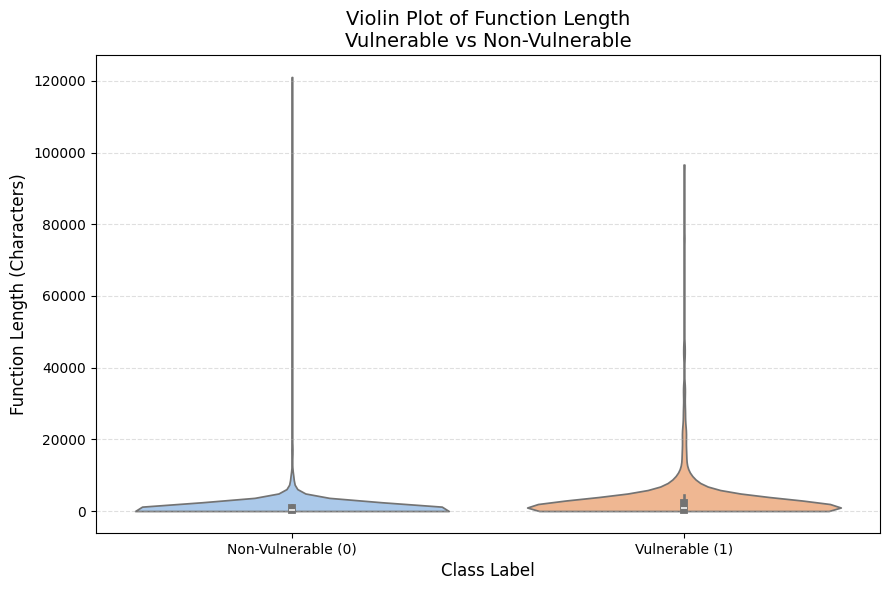

In [45]:
plt.figure(figsize=(9,6))
sns.violinplot(
    data=df,
    x="label",
    y="func_length",
    palette="pastel",
    cut=0
)

plt.xticks([0,1], ["Non-Vulnerable (0)", "Vulnerable (1)"])
plt.title("Violin Plot of Function Length\nVulnerable vs Non-Vulnerable", fontsize=14)
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Function Length (Characters)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [46]:
# Split the cleaned dataset into training and validation sets

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [47]:
# Sizes
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))


Training set size: 800
Validation set size: 200


In [48]:
# Label distribution
print("\nTraining label distribution:")
print(train_df['label'].value_counts())

print("\nValidation label distribution:")
print(val_df['label'].value_counts())


Training label distribution:
label
0    456
1    344
Name: count, dtype: int64

Validation label distribution:
label
0    114
1     86
Name: count, dtype: int64


In [49]:
# Preview first few rows
print("\n--- Training Set Preview ---")
print(train_df.head())

print("\n--- Validation Set Preview ---")
print(val_df.head())



--- Training Set Preview ---
                                                  code  label  func_length
504  void red_channel_client_set_header_sub_list(Re...      0          168
42   opj_image_t* bmptoimage(const char *filename, ...      1         5413
44                InlineLoginUI::~InlineLoginUI() {}\n      0           35
285  content::NavigationType NavigationController::...      0         2533
370  static int srpt_rx_mgmt_fn_tag(struct srpt_sen...      1          649

--- Validation Set Preview ---
                                                  code  label  func_length
471  void btm_sec_pin_code_request (UINT8 *p_bda)\n...      1         6801
977  bool PDFiumEngine::IsPointInEditableFormTextAr...      0          583
234  void PrintWebViewHelper::UpdateFrameAndViewFro...      0          624
0    xmlXPathNextPrecedingInternal(xmlXPathParserCo...      1          938
323  void Chapters::Atom::ShallowCopy(Atom& rhs) co...      1          323


In [50]:
#  Dataset Preparation & DataLoader Setup

tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")

class CodeDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        code = str(self.df.iloc[idx]['code'])
        label = int(self.df.iloc[idx]['label'])

        encoding = tokenizer(
            code,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_loader = DataLoader(CodeDataset(train_df), batch_size=8, shuffle=True)
val_loader   = DataLoader(CodeDataset(val_df), batch_size=8, shuffle=False)


In [51]:
class FastCodeModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Load model properly WITHOUT gradient_checkpointing
        self.base = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1")

        # Enable gradient checkpointing AFTER loading
        self.base.gradient_checkpointing_enable()

        # Freeze everything except last 2 layers
        for name, param in self.base.named_parameters():
            if ("encoder.layers.4" in name) or ("encoder.layers.5" in name):
                param.requires_grad = True
            else:
                param.requires_grad = False

        hidden = self.base.config.hidden_size

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask):
        out = self.base(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]   # CLS token
        logits = self.classifier(cls)
        return logits


In [52]:
# we define the training function here

def train_model(model, train_loader, val_loader, epochs=5):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr= 0.001
    )

    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, val_accuracies, epochs_list = [], [], [], []

    for epoch in range(1, epochs+1):
        print(f"\n===== Epoch {epoch}/{epochs} =====")

        model.train()
        running_loss = 0

        for batch in tqdm(train_loader):
            input_ids  = batch["input_ids"].to(device)
            mask       = batch["attention_mask"].to(device)
            labels     = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, mask)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train = running_loss / len(train_loader)

        # ========== VALIDATION ==========
        model.eval()
        val_loss = 0
        preds, trues = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                mask      = batch["attention_mask"].to(device)
                labels    = batch["labels"].to(device)

                logits = model(input_ids, mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                pred = torch.argmax(logits, dim=1)
                preds.extend(pred.cpu().numpy())
                trues.extend(labels.cpu().numpy())

        avg_val = val_loss / len(val_loader)
        acc = accuracy_score(trues, preds)

        train_losses.append(avg_train)
        val_losses.append(avg_val)
        val_accuracies.append(acc)
        epochs_list.append(epoch)

        print(f"Train Loss: {avg_train:.4f}")
        print(f"Val Loss:   {avg_val:.4f}")
        print(f"Val Acc:    {acc:.4f}")

    report = classification_report(trues, preds, output_dict=True)
    return model, epochs_list, train_losses, val_losses, val_accuracies, report


In [53]:
# we run the training function

model = FastCodeModel()

results = train_model(model, train_loader, val_loader, epochs= 50)

(
    trained_model,
    epochs_list,
    train_losses,
    val_losses,
    val_accuracies,
    eval_results
) = results



===== Epoch 1/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.7060
Val Loss:   0.6460
Val Acc:    0.5700

===== Epoch 2/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Train Loss: 0.6350
Val Loss:   0.5627
Val Acc:    0.7450

===== Epoch 3/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.6149
Val Loss:   0.5837
Val Acc:    0.6500

===== Epoch 4/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Train Loss: 0.5866
Val Loss:   0.5334
Val Acc:    0.7650

===== Epoch 5/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Train Loss: 0.5547
Val Loss:   0.5161
Val Acc:    0.7700

===== Epoch 6/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Train Loss: 0.5822
Val Loss:   0.5213
Val Acc:    0.7600

===== Epoch 7/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.5452
Val Loss:   0.5173
Val Acc:    0.7600

===== Epoch 8/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Train Loss: 0.5370
Val Loss:   0.5351
Val Acc:    0.7350

===== Epoch 9/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Train Loss: 0.5306
Val Loss:   0.5161
Val Acc:    0.7500

===== Epoch 10/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Train Loss: 0.5131
Val Loss:   0.5121
Val Acc:    0.7750

===== Epoch 11/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Train Loss: 0.5232
Val Loss:   0.4903
Val Acc:    0.7900

===== Epoch 12/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.4960
Val Loss:   0.5952
Val Acc:    0.7150

===== Epoch 13/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.5036
Val Loss:   0.5211
Val Acc:    0.7400

===== Epoch 14/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.4857
Val Loss:   0.5215
Val Acc:    0.7450

===== Epoch 15/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Train Loss: 0.4800
Val Loss:   0.5040
Val Acc:    0.7550

===== Epoch 16/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Train Loss: 0.4877
Val Loss:   0.5355
Val Acc:    0.7300

===== Epoch 17/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.4584
Val Loss:   0.6207
Val Acc:    0.6700

===== Epoch 18/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.4542
Val Loss:   0.5210
Val Acc:    0.7400

===== Epoch 19/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:34<00:00,  1.55s/it]


Train Loss: 0.4390
Val Loss:   0.5259
Val Acc:    0.7550

===== Epoch 20/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Train Loss: 0.4163
Val Loss:   0.5424
Val Acc:    0.7200

===== Epoch 21/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Train Loss: 0.4277
Val Loss:   0.5420
Val Acc:    0.7300

===== Epoch 22/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.4162
Val Loss:   0.5589
Val Acc:    0.7150

===== Epoch 23/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.4258
Val Loss:   0.5299
Val Acc:    0.7350

===== Epoch 24/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Train Loss: 0.4324
Val Loss:   0.6337
Val Acc:    0.6700

===== Epoch 25/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


Train Loss: 0.4062
Val Loss:   0.5757
Val Acc:    0.6800

===== Epoch 26/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


Train Loss: 0.4179
Val Loss:   0.6090
Val Acc:    0.7100

===== Epoch 27/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.4200
Val Loss:   0.5973
Val Acc:    0.7200

===== Epoch 28/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.3650
Val Loss:   0.5505
Val Acc:    0.7300

===== Epoch 29/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Train Loss: 0.3747
Val Loss:   0.5695
Val Acc:    0.7250

===== Epoch 30/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.3730
Val Loss:   0.5726
Val Acc:    0.7200

===== Epoch 31/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Train Loss: 0.3712
Val Loss:   0.5669
Val Acc:    0.7350

===== Epoch 32/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.3326
Val Loss:   0.5784
Val Acc:    0.7100

===== Epoch 33/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


Train Loss: 0.3596
Val Loss:   0.5911
Val Acc:    0.7100

===== Epoch 34/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Train Loss: 0.3360
Val Loss:   0.6595
Val Acc:    0.7100

===== Epoch 35/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.3062
Val Loss:   0.6419
Val Acc:    0.7050

===== Epoch 36/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


Train Loss: 0.3370
Val Loss:   0.6283
Val Acc:    0.7200

===== Epoch 37/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.3273
Val Loss:   0.6343
Val Acc:    0.7100

===== Epoch 38/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Train Loss: 0.3284
Val Loss:   0.6052
Val Acc:    0.7250

===== Epoch 39/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.3141
Val Loss:   0.6401
Val Acc:    0.7000

===== Epoch 40/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.2999
Val Loss:   0.6737
Val Acc:    0.6900

===== Epoch 41/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.3166
Val Loss:   0.6646
Val Acc:    0.7000

===== Epoch 42/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Train Loss: 0.2787
Val Loss:   0.6617
Val Acc:    0.7050

===== Epoch 43/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Train Loss: 0.3078
Val Loss:   0.6533
Val Acc:    0.7050

===== Epoch 44/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.2666
Val Loss:   0.6966
Val Acc:    0.6900

===== Epoch 45/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Train Loss: 0.2752
Val Loss:   0.7746
Val Acc:    0.6850

===== Epoch 46/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


Train Loss: 0.2705
Val Loss:   0.6705
Val Acc:    0.7150

===== Epoch 47/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Train Loss: 0.2523
Val Loss:   0.7237
Val Acc:    0.6950

===== Epoch 48/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


Train Loss: 0.2882
Val Loss:   0.7077
Val Acc:    0.6850

===== Epoch 49/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Train Loss: 0.2714
Val Loss:   0.6872
Val Acc:    0.6950

===== Epoch 50/50 =====


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Train Loss: 0.2902
Val Loss:   0.7108
Val Acc:    0.7050


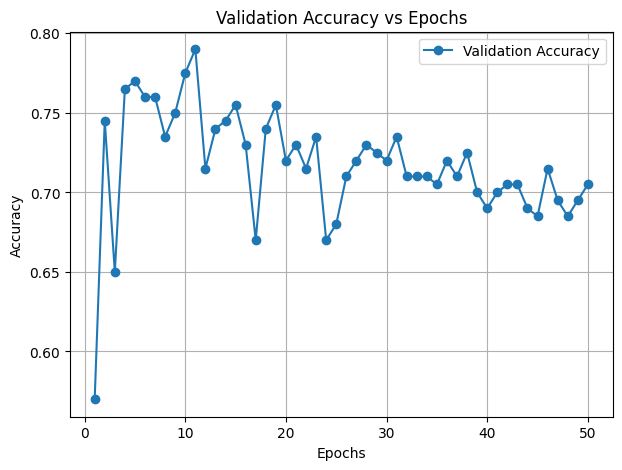

In [54]:
# Plotting Accuracy vs Epoch graph

plt.figure(figsize=(7,5))
plt.plot(epochs_list, val_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.grid(True)
plt.legend()
plt.show()


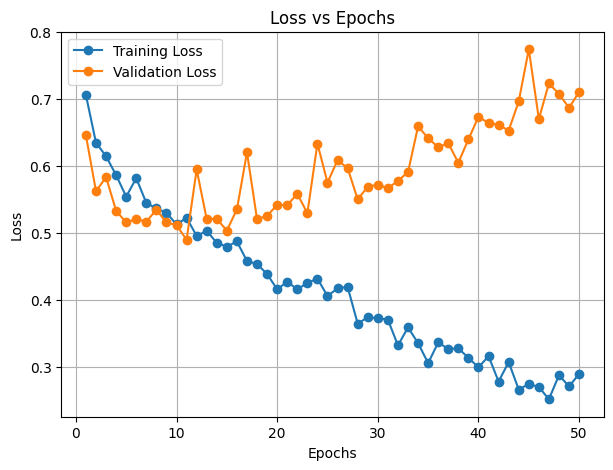

In [55]:
# Loss vs Epochs

plt.figure(figsize=(7,5))
plt.plot(epochs_list, train_losses, marker='o', label='Training Loss')
plt.plot(epochs_list, val_losses, marker='o', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.show()


In [56]:
# Generate predictions on the validation set

import torch
import torch.nn.functional as F

all_preds = []
all_probs = []
all_labels = []

device = "cuda" if torch.cuda.is_available() else "cpu"
trained_model.eval()
trained_model.to(device)

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = trained_model(input_ids, mask)
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class=1

        preds = torch.argmax(logits, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [60]:
%matplotlib inline

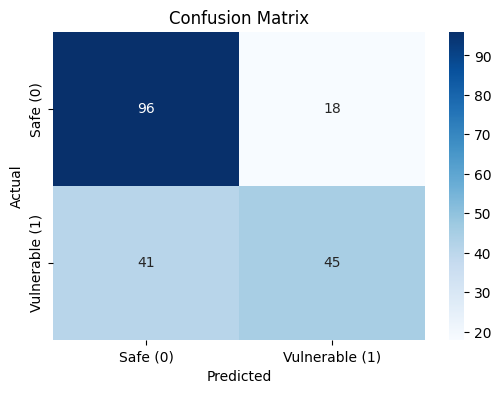

In [61]:
# Confusion Matrix
%matplotlib inline

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Safe (0)", "Vulnerable (1)"],
            yticklabels=["Safe (0)", "Vulnerable (1)"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


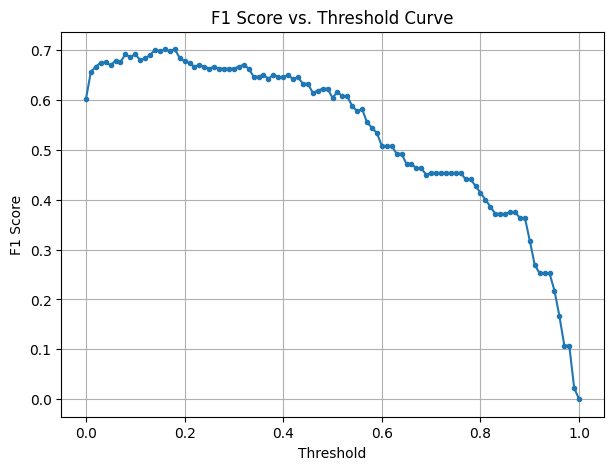

Best Threshold = 0.180
Best F1 Score  = 0.702


In [63]:
%matplotlib inline
import numpy as np
# Convert to numpy just to be sure
probs = np.array(all_probs)
labels = np.array(all_labels)

thresholds = np.linspace(0, 1, 101)  # 0.00 to 1.00 with step 0.01
f1_scores = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)

# Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, f1_scores, marker='.')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold Curve")
plt.grid(True)
plt.show()

# Show best threshold
best_idx = np.argmax(f1_scores)
print(f"Best Threshold = {thresholds[best_idx]:.3f}")
print(f"Best F1 Score  = {f1_scores[best_idx]:.3f}")

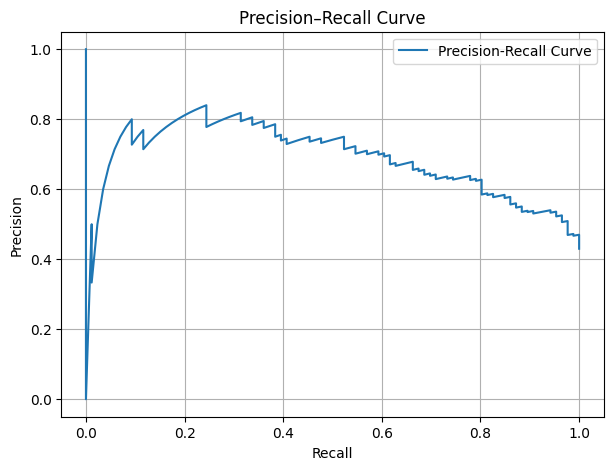

In [64]:
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label="Precision-Recall Curve")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


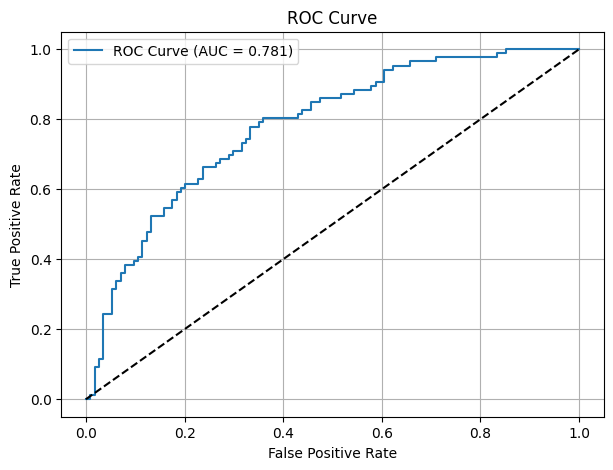

In [57]:


fpr, tpr, threshold = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.3f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal baseline

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()


In [58]:
import torch.nn.functional as F
from tqdm import tqdm

def generate_risk_score_csv(model, df, tokenizer, filename="code_risk_scores.csv", max_len=128):
    """
    Generate a CSV containing:
    - code
    - risk_score (probability of class 1)
    - predicted_label
    - true_label

    Works directly with your existing FastCodeModel.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    all_codes = []
    all_true = []
    all_pred = []
    all_probs = []

    with torch.no_grad():
        for i in tqdm(range(len(df)), desc="Generating scores"):
            code = df.iloc[i]["code"]
            label = int(df.iloc[i]["label"])

            enc = tokenizer(
                code,
                truncation=True,
                padding="max_length",
                max_length=max_len,
                return_tensors="pt"
            )

            input_ids = enc["input_ids"].to(device)
            mask = enc["attention_mask"].to(device)

            logits = model(input_ids, mask)
            probs = F.softmax(logits, dim=1)

            risk_score = float(probs[:, 1].cpu().numpy()[0])
            predicted = int(torch.argmax(probs, dim=1).cpu().numpy()[0])

            all_codes.append(code)
            all_true.append(label)
            all_pred.append(predicted)
            all_probs.append(risk_score)

    # Create DataFrame
    out_df = pd.DataFrame({
        "code": all_codes,
        "true_label": all_true,
        "predicted_label": all_pred,
        "risk_score": all_probs
    })

    # Save to CSV
    out_df.to_csv(filename, index=False)
    print(f"\nCSV file saved as: {filename}")

    return out_df


In [ ]:
risk_df = generate_risk_score_csv(
    model=trained_model,
    df=df,                    # original dataframe
    tokenizer=tokenizer,
    filename="risk_scores.csv",
    max_len=128
)


Generating scores: 100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]



CSV file saved as: risk_scores.csv
